# Lab 6: Random Forest Regression on Malagasy Mammal Traits

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

In [2]:
dat = pd.read_csv("/courses/EDS232/Data/MamTraitData.csv", encoding="ISO-8859-1").rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; carcasses': 'Diet_Other'
})

dat.shape

(214, 24)

In [3]:
# Drop columns that have more than 40% of the observations missing
dat.drop(columns = dat.columns[dat.isna().sum() / len(dat) * 100 > 40], inplace = True)

# Print final df shape
print(f"Final DataFrame shape: {dat.shape}")

Final DataFrame shape: (214, 17)


### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [4]:
# Check NAs in numeric columns
dat.select_dtypes(exclude=["object"]).isna().sum()

AdultBodyMass       3
HabitatBreadth     26
ActivityCycle      22
ForagingStratum    24
LitterSize         83
Dry                 0
Humid               0
Montane             0
Subarid             0
Subhumid            0
dtype: int64

In [5]:
# Impute with KNN Imputer
knn_impute = KNNImputer(n_neighbors = 5)
dat_knn_impute = knn_impute.fit_transform(dat.select_dtypes(exclude = ["object"]))
dat_knn_impute = pd.DataFrame(dat_knn_impute, columns=dat.select_dtypes(exclude=["object"]).columns)

# Reattach object columns to the imputed data
dat_cleaned = pd.concat([dat_knn_impute, dat.select_dtypes(include = ["object"])], axis=1)

# Check to make sure there are no NAs
dat_cleaned.isna().sum()

AdultBodyMass         0
HabitatBreadth        0
ActivityCycle         0
ForagingStratum       0
LitterSize            0
Dry                   0
Humid                 0
Montane               0
Subarid               0
Subhumid              0
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
dtype: int64

### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [6]:
# Create a new column that sums the 5 climates
dat_cleaned["nClimates"] = dat_cleaned["Dry"] + dat_cleaned["Humid"] + dat_cleaned["Montane"] + dat_cleaned["Subarid"] + dat_cleaned["Subhumid"]

# Verify
dat_cleaned.head()

,AdultBodyMass,HabitatBreadth,ActivityCycle,ForagingStratum,LitterSize,Dry,Humid,Montane,Subarid,Subhumid,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,nClimates
0,78.0,1.0,2.0,3.0,1.000,0.0,1.0,1.0,0.0,1.0,yes,no,yes,yes,no,yes,no,3.0
1,1082.0,1.0,1.0,3.0,1.402,0.0,1.0,0.0,0.0,1.0,no,no,yes,no,no,yes,no,2.0
2,946.0,2.0,1.0,3.0,4.692,1.0,0.0,0.0,0.0,0.0,no,no,yes,no,no,yes,no,1.0
3,1180.0,2.0,1.0,3.0,1.010,1.0,1.0,1.0,0.0,1.0,no,no,yes,no,no,yes,no,4.0
4,1212.5,1.0,1.0,3.0,1.540,0.0,1.0,0.0,1.0,1.0,no,no,yes,no,no,yes,no,3.0


In [7]:
# Drop original climate columns
dat_cleaned = dat_cleaned.drop(columns = ["Dry", "Humid", "Montane", "Subarid", "Subhumid"])

# Verify
dat_cleaned.columns

Index(['AdultBodyMass', 'HabitatBreadth', 'ActivityCycle', 'ForagingStratum',
       'LitterSize', 'Diet_Invertebrates', 'Diet_Vertebrates', 'Diet_Fruits',
       'Diet_Flowers', 'Diet_Seeds', 'Diet_Plants', 'Diet_Other', 'nClimates'],
      dtype='object')

In [8]:
# Apply LabelEncoder to each categorical column
for col in dat_cleaned.select_dtypes(include = ["object"]):
    
    label_encoders = {}
    le = LabelEncoder()
    dat_cleaned[col] = le.fit_transform(dat_cleaned[col])
    label_encoders[col] = le

# Verify
dat_cleaned.dtypes

AdultBodyMass         float64
HabitatBreadth        float64
ActivityCycle         float64
ForagingStratum       float64
LitterSize            float64
Diet_Invertebrates      int64
Diet_Vertebrates        int64
Diet_Fruits             int64
Diet_Flowers            int64
Diet_Seeds              int64
Diet_Plants             int64
Diet_Other              int64
nClimates             float64
dtype: object

In [9]:
# Define features and target
X = dat_cleaned.drop(columns = "nClimates")
y = dat_cleaned["nClimates"]

In [10]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 808)

### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

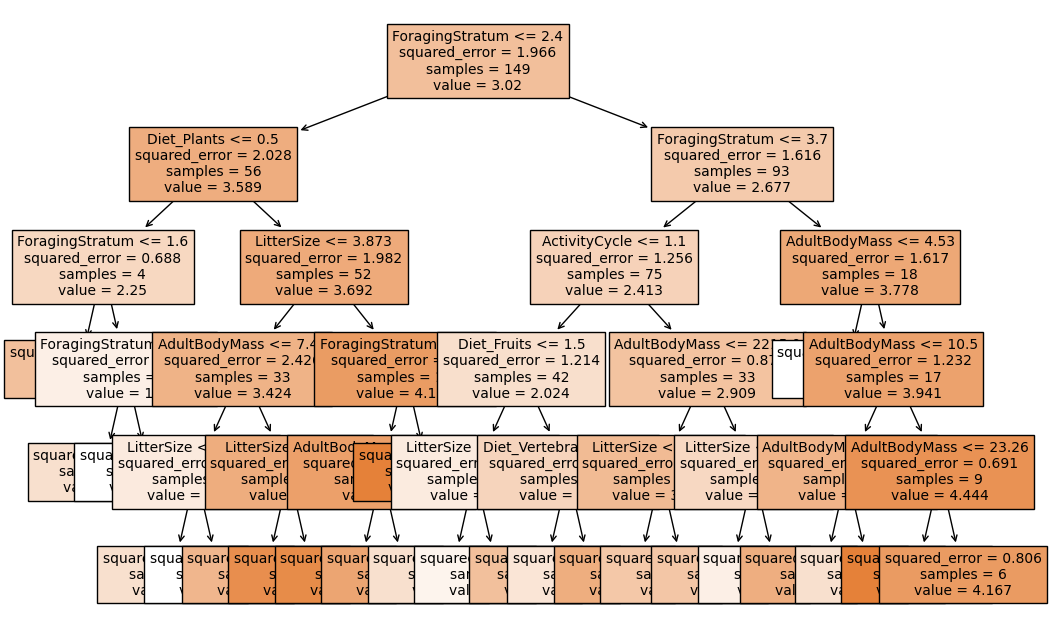

In [11]:
# Initialize the DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth = 5, random_state = 808)
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_test)

# Visualize the decision tree
plt.figure(figsize = (12, 8))
plot_tree(dt, filled = True, feature_names = X.columns, fontsize = 10)
plt.show()

In [12]:
# Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 1.4462


Based on the way this tree looks, what would you guess the most important variable to be?

Based on the wau the tree looks, I would guess the most important variable is ForagingStratum because it is the root of the tree.

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [13]:
# Define a paramter grid
param_grid = {
    "max_features": ["sqrt", 6, None],
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 4, 5, 6, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor()

# Use GridSearchCV
gs = GridSearchCV(rf, param_grid = param_grid, cv = 5, scoring = "neg_mean_squared_error", n_jobs = -1, return_train_score = True)

In [14]:
# Carry out the search
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['sqrt', 6, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [15]:
# Train the best estimator 
best_rf = gs.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_split=10,
                      n_estimators=50)

### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

In [16]:
# Make predictions with the best random forest model
y_pred_rf = best_rf.predict(X_test)

# Print the best set of parameter values
print(f"Best Hyperparameters: {gs.best_params_}")

Best Hyperparameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}


In [17]:
# Evaluate model performance (MSE)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Mean Squared Error of the Best Random Forest Model: {mse_rf:.4f}")

Mean Squared Error of the Best Random Forest Model: 1.4025


In [18]:
# Extract feature importances
feature_importances = best_rf.feature_importances_

In [19]:
# Create a df for plotting
importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances
})

# Sort in descending of importance
importances_df = importances_df.sort_values(by = "Importance", ascending = False)

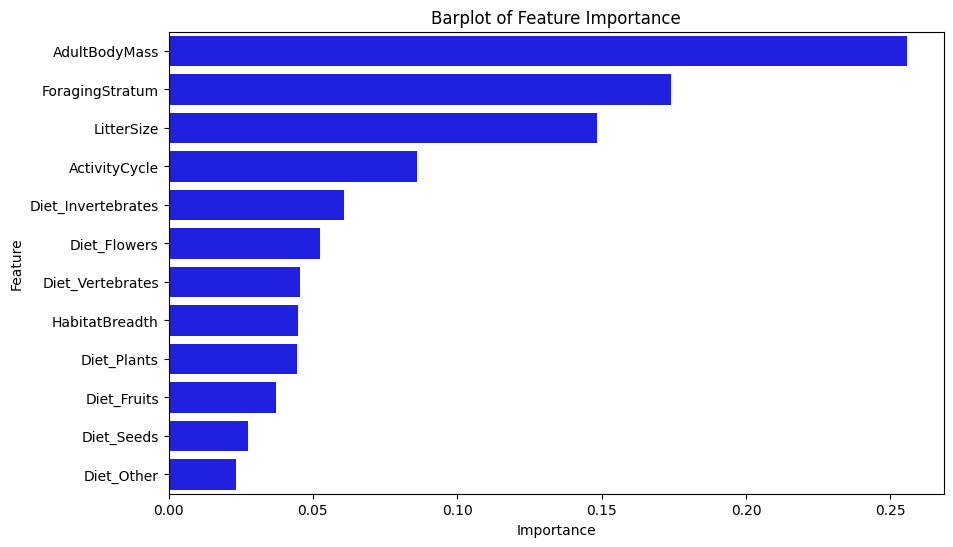

In [20]:
# Create a barplot
plt.figure(figsize = (10, 6))
sns.barplot(data = importances_df,
            x = "Importance", 
            y = "Feature",
            color = "blue")

# Add a title
plt.title("Barplot of Feature Importance")

# Display plot
plt.show()

Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

The ensemble achieved better accuracy than the single decision tree. As illustrated in the bar plot, adult body mass is the most influential trait on a species' climate adaptability. Following adult body mass, litter size ranks second, and foraging stratum is third. Species with larger body sizes tend to have a broader tolerance for varying climates. Additionally, larger litter sizes may contribute to higher reproductive success, while more flexible foraging behaviors are better suited for adaptation.